# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# stundent details example: John S. 9812
#                       student details 1: Oran L. 9100
# (if exists)           student details 2: Or A. 3736
# (if exists)           student details 3: Yuval T. 
# (if exists&premitted) student details 4: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: ChatGPT
Goal: to understand the assignment and the steps better.
Propmpt1: Supervised Learning Flow for the Wine Dataset + sent wine_descripiton.txt
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
We got the wine dataset problem, it has 178 instances and 13 features like: Alcohol, Malic acid, Ash, Magnesium, etc.
We'll need to use ML algorithms to classify the wine based on features given.
We will train and test the model based on the csv file given and we will use the tools and methods learned from the course.




    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [91]:
import sys                       
import os                          
import seaborn as sns
import matplotlib.pyplot as plt                             
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer,classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
import statistics


In [93]:
#מטרה: לבדוק שהנתונים נטענו כראוי ולוודא את מבנה העמודות
train_df = pd.read_csv('wine_train.csv')
test_df = pd.read_csv('wine_test.csv')

print("Train Set (first 5 rows):")
print(train_df.head())

print("\nTest Set (first 5 rows):")
print(test_df.head())

Train Set (first 5 rows):
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    12.08        1.83  2.32               18.5       81.0           1.60   
1    13.58        2.58  2.69               24.5      105.0           1.55   
2    12.37        0.94  1.36               10.6       88.0           1.98   
3    11.82        1.72  1.88               19.5       86.0           2.50   
4    13.16        3.57  2.15               21.0      102.0           1.50   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        1.50                  0.52             1.64             2.40  1.08   
1        0.84                  0.39             1.54             8.66  0.74   
2        0.57                  0.28             0.42             1.95  1.05   
3        1.64                  0.37             1.42             2.06  0.94   
4        0.55                  0.43             1.30             4.00  0.60   

   od280/od315_of_diluted_wines  pro

<Axes: xlabel='target', ylabel='count'>

Text(0.5, 1.0, 'Class Distribution in Training Set')

Text(0.5, 0, 'Wine Class')

Text(0, 0.5, 'Count')

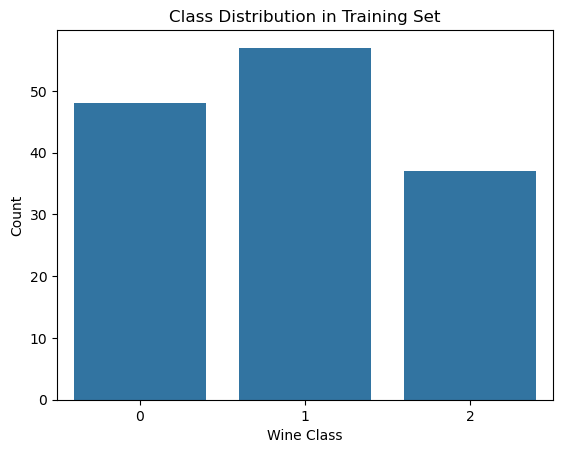

In [95]:
#מטרה: לוודא אם קבוצות היין מאוזנות, דבר שמשפיע על ביצועי המודל
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution in Training Set')
plt.xlabel('Wine Class')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='alcohol', ylabel='color_intensity'>

Text(0.5, 1.0, 'Alcohol vs Color Intensity by Class')

Text(0.5, 0, 'Alcohol')

Text(0, 0.5, 'Color Intensity')

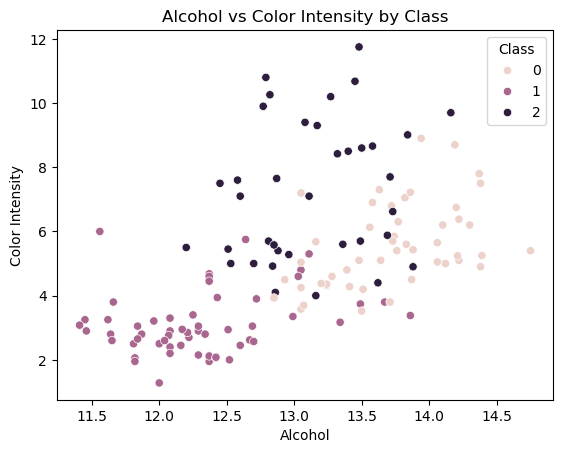

In [97]:
#מטרה: לבדוק אם קיימים הבדלים ויזואליים ברורים בין הקלאסים לפי שתי תכונות – מעיד על פוטנציאל הפרדה טובה של המודל
sns.scatterplot(data=train_df, x="alcohol", y="color_intensity", hue="target")
plt.title("Alcohol vs Color Intensity by Class")
plt.xlabel("Alcohol")
plt.ylabel("Color Intensity")
plt.legend(title="Class")
plt.show()

<Axes: xlabel='target', ylabel='phenol_ratio'>

Text(0.5, 1.0, 'Phenol Ratio (Flavanoids / Nonflavanoid Phenols) by Class')

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Phenol Ratio')

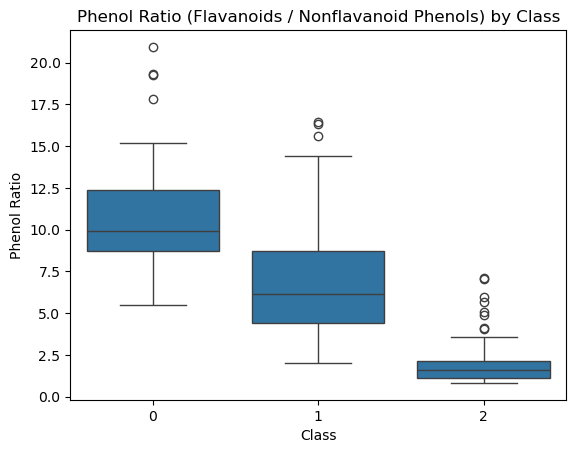

In [99]:
#מטרה: להראות שימוש בהנדסת תכונות – חישוב תכונה חדשה שיכולה לעזור למודל להבחין בין קבוצות
train_df["phenol_ratio"] = train_df["flavanoids"] / (train_df["nonflavanoid_phenols"] + 1e-6)
sns.boxplot(x="target", y="phenol_ratio", data=train_df)
plt.title("Phenol Ratio (Flavanoids / Nonflavanoid Phenols) by Class")
plt.xlabel("Class")
plt.ylabel("Phenol Ratio")
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [102]:
train_df = pd.read_csv('wine_train.csv')
X = train_df.drop('target', axis=1)
y = train_df['target']

#יחס פנולים feature engineering
def add_phenol_ratio(X):
    X = X.copy()
    X['phenol_ratio'] = X['flavanoids'] / (X['nonflavanoid_phenols'] + 1e-6)
    return X

# דירוג לפי macro F1
scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# אפשרויות Feature Engineering
feature_eng_options = {
    'none': FunctionTransformer(lambda x: x),
    'phenol_ratio': FunctionTransformer(add_phenol_ratio)
}

# מודלים עם גריד של הייפרפרמטרים
models = [
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5]
        }
    },
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(max_iter=1000),
        'param_grid': {
            'model__C': [0.1, 1.0],
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs']
        }
    }
]

results = []

for fe_name, fe_transform in feature_eng_options.items():
    for m in models:
        pipe = Pipeline([
            ('feature_eng', fe_transform),
            ('scaler', StandardScaler()),
            ('model', m['model'])
        ])
        
        grid = GridSearchCV(
            pipe,
            m['param_grid'],
            cv=cv,
            scoring=scorer,
            n_jobs=-1
        )
        grid.fit(X, y)

        results.append({
            'Feature_Engineering': fe_name,
            'Model': m['name'],
            'Best_F1_Macro': grid.best_score_,
            'Best_Params': grid.best_params_
        })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Best_F1_Macro", ascending=False))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function <lambda> at 0x000001D5BD319EE0>)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function <lambda> at 0x000001D5BD319EE0>)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1.0], 'model__penalty': ['l2'],
                         'model__solver': ['lbfgs']},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function add_phenol_ratio at 0x000001D5BD319C60>)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FunctionTransformer(func=<function add_phenol_ratio at 0x000001D5BD319C60>)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1.0], 'model__penalty': ['l2'],
                         'model__solver': ['lbfgs']},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

  Feature_Engineering               Model  Best_F1_Macro  \
1                none  LogisticRegression       0.979488   
3        phenol_ratio  LogisticRegression       0.979488   
2        phenol_ratio        RandomForest       0.979212   
0                none        RandomForest       0.972545   

                                         Best_Params  
1  {'model__C': 0.1, 'model__penalty': 'l2', 'mod...  
3  {'model__C': 0.1, 'model__penalty': 'l2', 'mod...  
2  {'model__max_depth': 3, 'model__n_estimators':...  
0  {'model__max_depth': 5, 'model__n_estimators':...  


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [108]:
def add_phenol_ratio(X):
    X = X.copy()
    X['phenol_ratio'] = X['flavanoids'] / (X['nonflavanoid_phenols'] + 1e-6)
    return X

# הגדרת pipeline עם הקומבינציה שנבחרה
final_pipeline = Pipeline([
    ('feature_eng', FunctionTransformer(add_phenol_ratio)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42))
])

# אימון סופי על כל הדאטה
final_pipeline.fit(X, y)

Pipeline(steps=[('feature_eng',
                 FunctionTransformer(func=<function add_phenol_ratio at 0x000001D5BE53FE20>)),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=5, random_state=42))])

## Part 5 - Apply on test and show model performance estimation

In [110]:
test_df = pd.read_csv('wine_test.csv')
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

y_pred = final_pipeline.predict(X_test)


print('5 first predictions:')
print(pd.DataFrame({
    "True Label": y_test.iloc[:5].values,
    "Predicted": y_pred[:5]
}))


print('\n full prediction:')
print(classification_report(y_test, y_pred, digits=4))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'\n F1 Macro Score: {macro_f1:.4f}')

5 first predictions:
   True Label  Predicted
0           2          2
1           0          0
2           2          2
3           1          1
4           2          2

 full prediction:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        11
           1     1.0000    1.0000    1.0000        14
           2     1.0000    1.0000    1.0000        11

    accuracy                         1.0000        36
   macro avg     1.0000    1.0000    1.0000        36
weighted avg     1.0000    1.0000    1.0000        36


 F1 Macro Score: 1.0000
